In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
from IPython.display import display, Math, Latex

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [8]:
from scipy.spatial.distance import correlation

In [9]:
from gradient_solver import *

In [10]:
EXPLAINING_FEATURE_NAMES = list(config.EXPLAINING_FEATURE_NAMES.keys())
observed_features = list(config.OBSERVABLE_FEATURE_NAMES.keys())

df_observable = DataPreparator.read_excel_sheet(
        config.INPUT_FILE_OBSERVABLE_FEATURES, observed_features
    )

df_explainable = DataPreparator.read_excel_sheet(
    config.INPUT_FILE_EXPLAINING_FEATURES, EXPLAINING_FEATURE_NAMES
)

In [11]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [67]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0        True
1       False
2       False
3        True
4        True
        ...  
4289    False
4290    False
4291     True
4292    False
4293    False
Name: pattern_type, Length: 4294, dtype: bool
0.6590591523055426
[7 8 2 4 6 6 2 7 7 7 4 7 7 6 6 5 7 2 4 0 7 6 8]
[7 0 0 4 6 7 1 6 0 5 4 5 6 6 6 5 7 2 6 0 7 6 6]


In [68]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [69]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Country,Australia,Benin,Brazil,Canada,China,Colombia,Congo,Costa Rica,DRC,Dominican Republic,...,South Africa,South Korea,Spain,Sweden,Taiwan,Thailand,Uganda,United Arab Emirates,United Kingdom,United States of America
Country,,,,,,,,,,,,,,,,,,,,,
Australia,0.000000,0.000576,0.000329,0.000220,0.000381,0.000662,0.000682,0.000537,0.000612,0.000591,...,0.000217,0.000574,0.000527,0.000221,0.001449,0.000797,0.000665,0.000766,0.000409,0.000294
Benin,0.000576,0.000000,0.000676,0.000443,0.000310,0.000547,0.000668,0.000662,0.000667,0.000503,...,0.000514,0.000398,0.000497,0.000529,0.001322,0.000568,0.000612,0.000525,0.000385,0.000376
Brazil,0.000329,0.000676,0.000000,0.000362,0.000524,0.000522,0.000651,0.000320,0.000638,0.000451,...,0.000333,0.000601,0.000432,0.000441,0.001471,0.000756,0.000776,0.000665,0.000628,0.000417
Canada,0.000220,0.000443,0.000362,0.000000,0.000277,0.000527,0.000615,0.000487,0.000630,0.000466,...,0.000234,0.000441,0.000392,0.000248,0.001434,0.000722,0.000620,0.000638,0.000309,0.000245
China,0.000381,0.000310,0.000524,0.000277,0.000000,0.000524,0.000762,0.000585,0.000653,0.000451,...,0.000359,0.000351,0.000379,0.000364,0.001345,0.000568,0.000582,0.000564,0.000277,0.000200


In [70]:
df_observable_distances.index

Index(['Australia', 'Benin', 'Brazil', 'Canada', 'China', 'Colombia', 'Congo',
       'Costa Rica', 'DRC', 'Dominican Republic', 'Ecuador', 'France',
       'Germany', 'India', 'Ireland', 'Japan', 'Kenya', 'Mexico', 'Morocco',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Russia', 'Saudi Arabia',
       'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain',
       'Sweden', 'Taiwan', 'Thailand', 'Uganda', 'United Arab Emirates',
       'United Kingdom', 'United States of America'],
      dtype='object', name='Country')

In [12]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

@torch.jit.script
def apply_weights(A, w):
    return w.unsqueeze(-1)*A*w

@torch.jit.script
def weighted_mean(A, w):
    _w = w / w.sum()
    return ((_w*A).sum(dim=1)*_w).sum()

@torch.jit.script
def weighted_pearson_corrcoef(x:torch.Tensor, y:torch.Tensor, w:torch.Tensor) -> torch.Tensor:
    '''
    Calculates the Person correlation coefficient.
    PyTorch equivalent to numpy.corrcoef(x, y)[0, 1].
    '''

    A = apply_weights(x, w)
    Am = weighted_mean(A, w)
    vx = apply_weights(A - Am, w)

    B = apply_weights(y, w)
    Bm = weighted_mean(B, w)
    vy = apply_weights(B - Bm, w)

    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-20)

In [13]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable_distances:pd.DataFrame, num_samples:int=1, penalty=0., device='cpu', dtype=torch.float32):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device)
        self.tensor_observable_distances = torch.tensor(df_observable_distances.to_numpy(), dtype=self.dtype, device=self.device)

        self.feature_names = list(df_explainable.columns)

        self.N = self.tensor_explainable.shape[0]
        self.M = len(self.feature_names)
        self._range = torch.arange(self.N, device=self.device)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)

        self.num_samples = num_samples
        
        alpha, beta = mean_std_to_beta_params(0.5, 0.05)

        noise_1 = torch.rand(len(self.feature_names))
        noise_2 = torch.rand(len(self.feature_names))

        alpha_init = alpha * torch.ones(len(self.feature_names)) * 0.9 + noise_1 * 0.1
        beta_init  = beta  * torch.ones(len(self.feature_names)) * 0.9 + noise_2 * 0.1

        self.add_param('alpha', torch.log(alpha_init), lambda x: x.exp())
        self.add_param('beta',  torch.log(beta_init), lambda x: x.exp())

        self.best_loss = None 
        self.best_weights = None
        
    def get_feature_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)}
        return feature_dict
    
    def get_feature_certainty(self) -> dict:
        s = Beta(self.constrained('alpha'), self.constrained('beta')).stddev.clone().detach().numpy()
        stdev_dict = {feature_name:float(std) for feature_name, std in zip(self.feature_names, s)}
        return stdev_dict
    
    def save_if_best_loss(self, loss, feature_weights):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()

    def sample(self, num_samples:int=1000):
        samples = Beta(self.constrained('alpha'), self.constrained('beta')).sample([num_samples]).numpy()
        res_df = pd.DataFrame({self.feature_names[i]:samples[:, i] for i in range(len(self.feature_names))})
        return res_df
    
    def plot(self, num_samples:int=1000):
        plt.figure(figsize=(10, 5))
        sns.barplot(self.sample(num_samples))

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:
 
        # Sample feature_weights
        feature_weights = Beta(self.constrained('alpha'), self.constrained('beta')).rsample([self.num_samples]).mean(dim = 0)
      
        # Construct the distance_matrix 
        feature_distances = construct_distance_matrix(
            A=self.tensor_explainable, feature_weights=feature_weights, normalize=False
        )

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, self.tensor_observable_distances)

        # Loss
        loss = torch.log(1. + 1e-10 -coef)

        self.save_if_best_loss(loss, feature_weights)

        return loss

In [95]:
class BayesFeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable_distances:pd.DataFrame, num_samples:int=1, penalty=0., device='cpu', dtype=torch.float32):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device)
        self.tensor_observable_distances = torch.tensor(df_observable_distances.to_numpy(), dtype=self.dtype, device=self.device)

        self.feature_names = list(df_explainable.columns)

        self.N = self.tensor_explainable.shape[0]
        self.M = len(self.feature_names)
        self._range = torch.arange(self.N, device=self.device)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)

        self.num_samples = num_samples
        
        alpha, beta = mean_std_to_beta_params(0.5, 0.05)

        noise_1 = torch.rand(len(self.feature_names))
        noise_2 = torch.rand(len(self.feature_names))

        alpha_init = alpha * torch.ones(len(self.feature_names)) * 0.9 + noise_1 * 0.1
        beta_init  = beta  * torch.ones(len(self.feature_names)) * 0.9 + noise_2 * 0.1

        self.add_param('alpha', torch.log(alpha_init), lambda x: x.exp())
        self.add_param('beta',  torch.log(beta_init), lambda x: x.exp())

        self.best_loss = None 
        self.best_weights = None
        self.best_coef = None
        self.alpha = None
        self.beta  = None
        
    def get_feature_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)}
        return feature_dict
    
    def get_feature_certainty(self) -> dict:
        s = Beta(self.constrained('alpha'), self.constrained('beta')).stddev.clone().detach().numpy()
        stdev_dict = {feature_name:float(std) for feature_name, std in zip(self.feature_names, s)}
        return stdev_dict
    
    def save_if_best_loss(self, loss, feature_weights, coef, alpha, beta):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_coef =  coef.clone().detach()
            self.alpha = alpha.clone().detach()
            self.beta = beta.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_coef =  coef.clone().detach()
            self.alpha = alpha.clone().detach()
            self.beta = beta.clone().detach()

    def sample(self, num_samples:int=1000):
        samples = Beta(self.alpha, self.beta).sample([num_samples]).numpy()
        res_df = pd.DataFrame({self.feature_names[i]:samples[:, i] for i in range(len(self.feature_names))})
        return res_df
    
    def plot(self, num_samples:int=1000):
        plt.figure(figsize=(10, 5))
        sns.barplot(self.sample(num_samples))

    def get_coef(self):
        return self.best_coef

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:
 
        # Sample feature_weights
        feature_weights = Beta(self.constrained('alpha'), self.constrained('beta')).rsample([self.num_samples]).mean(dim = 0)
      
        # Construct the distance_matrix 
        feature_distances = construct_distance_matrix(
            A=self.tensor_explainable, feature_weights=feature_weights, normalize=False
        )

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, self.tensor_observable_distances)

        # KL-Divergence term
        alpha_prior = torch.tensor(1.0, device=self.device, dtype=self.dtype)
        beta_prior = torch.tensor(1.0, device=self.device, dtype=self.dtype)
        kl_div = kl_divergence(
            Beta(self.constrained('alpha'), self.constrained('beta')),
            Beta(alpha_prior, beta_prior)
        ).sum()

        # Loss
        likelihood_loss = torch.log(1. + 1e-10 -coef)
        loss = likelihood_loss + self.penalty * kl_div

        self.save_if_best_loss(loss, feature_weights, coef, self.constrained('alpha'), self.constrained('beta'))

        return loss

In [96]:
def uniform_list(von, bis, num):
    lis = list(Uniform(von, bis).sample([num]))
    return [float(li) for li in lis]

In [97]:
from gradient_solver import _construct_distance_matrix

In [98]:
output_path = f"{config.OUTPUT_FOLDER_BASE}observables/"
df_observable_distances = pd.read_excel(
    f"{output_path}{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)

In [99]:
save_folder: str = f"{config.OUTPUT_FOLDER_BASE}base_data/"
df_explainable = pd.read_excel(
    f"{save_folder}{config.DATASET_NAME}_explainable_dataset_scaled.xlsx",
    index_col=0,
)

In [100]:
df_explainable.shape, df_observable_distances.shape

((35, 16), (35, 35))

In [101]:
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
valid_indices.sort()
valid_indices

array(['Australia', 'Brazil', 'Canada', 'China', 'Colombia', 'Costa Rica',
       'Dominican Republic', 'Ecuador', 'France', 'Germany', 'India',
       'Ireland', 'Japan', 'Kenya', 'Mexico', 'Morocco', 'Nigeria',
       'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Russia', 'Saudi Arabia', 'Singapore', 'Slovakia', 'South Africa',
       'South Korea', 'Spain', 'Sweden', 'Thailand',
       'United Arab Emirates', 'United Kingdom',
       'United States of America'], dtype=object)

In [102]:
for d in [df_explainable, df_observable_distances]:
    for idx in d.index:
        if idx not in valid_indices:
            print(idx)

In [103]:
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
valid_indices.sort()
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices, valid_indices]

In [113]:
model = BayesFeatureSelectionModel(
    df_explainable=df_explainable,
    df_observable_distances=df_observable_distances,
    num_samples=1,
    penalty = 1e-3
)

# After this many steps, the learning rate is halved
HALFLIFE = 650

optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['alpha'], 'lr': 0.001, 'momentum': 0.5},
        {'params': model.parameters['beta'],  'lr': 0.001, 'momentum': 0.5},
    ]
)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))

In [114]:
print(f'Loss before training: {model.loss().clone().detach()}')
trainer.train(epochs = 2000, timeout=60000)

Loss before training: -0.18918102979660034
1/2000 --- Mean Loss : -0.26521849632263184
2/2000 --- Mean Loss : -0.3352627456188202
3/2000 --- Mean Loss : -0.36968693137168884
4/2000 --- Mean Loss : -0.3902307450771332
5/2000 --- Mean Loss : -0.40125367045402527
6/2000 --- Mean Loss : -0.40934768319129944
7/2000 --- Mean Loss : -0.4160565435886383
8/2000 --- Mean Loss : -0.42071443796157837
9/2000 --- Mean Loss : -0.4240497946739197
10/2000 --- Mean Loss : -0.42775025963783264
11/2000 --- Mean Loss : -0.4304952025413513
12/2000 --- Mean Loss : -0.43297871947288513
13/2000 --- Mean Loss : -0.4350971579551697
14/2000 --- Mean Loss : -0.4375927150249481
15/2000 --- Mean Loss : -0.43887564539909363
16/2000 --- Mean Loss : -0.44051751494407654
17/2000 --- Mean Loss : -0.44283097982406616
18/2000 --- Mean Loss : -0.4441204071044922
19/2000 --- Mean Loss : -0.44622573256492615
20/2000 --- Mean Loss : -0.4480048716068268
21/2000 --- Mean Loss : -0.4490512013435364
22/2000 --- Mean Loss : -0.4515

In [115]:
model.get_coef()

tensor(0.5006)

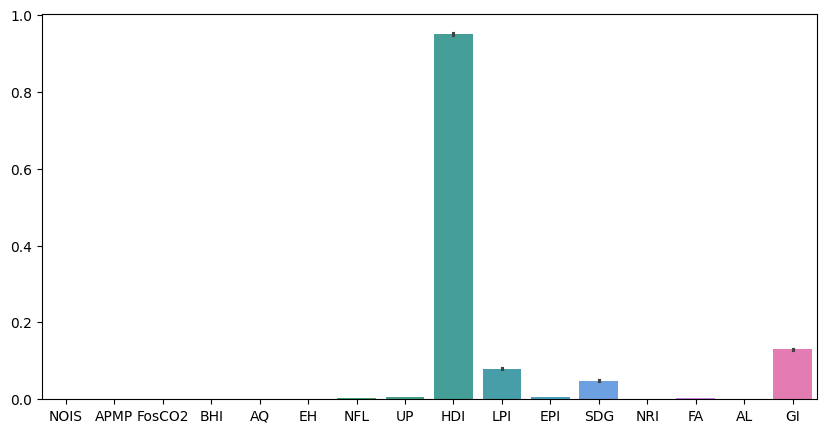

In [116]:
model.plot()

In [ ]:
['HDI', 'LPI', 'SDG', 'GI']

In [ ]:
...